In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

import sys
sys.path.append("../src")

from dnadb import dna, fastq, sample
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
import tf_utilities as tfu
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import normalized_mutual_info_score
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist
import wandb

from deepdna.data.dataset import Dataset
from deepdna.data import metrics
from deepdna.nn.data_generators import SequenceGenerator
from deepdna.nn.losses import SortedLoss
from deepdna.nn.models import load_model, dnabert, setbert
from deepdna.nn import layers

In [4]:
SEED = 0

In [5]:
tfu.devices.select_gpu(1)

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 [PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')])

In [6]:
api = wandb.Api()

## Models

In [7]:
path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-silva-64:v3").download()
dnabert_encoder = dnabert.DnaBertEncoderModel(
    load_model(path, dnabert.DnaBertPretrainModel).base,
    chunk_size=256
)

wandb:   4 of 4 files downloaded.  


In [8]:
# path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-hopl-64:latest").download()
path = Path("~/.cache/wandb/wandb/run-20230502_161947-83qte62b/files/model").expanduser()
pretrained_model = tf.keras.models.load_model(path, custom_objects={"SortedLoss": SortedLoss})
pretrained_model

In [9]:
setbert_model = setbert.SetBertModel(
    dnabert_encoder,
    embed_dim=64,
    max_set_len=1000,
    stack=8,
    num_heads=8)
setbert_model.layers[1].set_weights(pretrained_model.base.model.get_weights())

Number of outputs: 8


In [10]:
setbert_encoder = setbert.SetBertEncoderModel(setbert_model)

---

## Data

In [11]:
dataset_path = Path(f"/home/dwl2x/work/Datasets/hopland/")

Find all FASTQ DB sample files to choose from across all of the datasets and shuffle them.

In [12]:
sample_paths = [path for path in dataset_path.iterdir()]
sample_paths.sort()
len(sample_paths)

128

Pick some samples.

In [13]:
chosen_sample_paths = sample_paths[::2] + sample_paths[1::2]
chosen_sample_paths

[PosixPath('/home/dwl2x/work/Datasets/hopland/Ur1-B-16S_S197_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/work/Datasets/hopland/Ur10-B-16S_S207_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/work/Datasets/hopland/Ur11-B-16S_S216_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/work/Datasets/hopland/Ur12-B-16S_S225_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/work/Datasets/hopland/Ur13-B-16S_S234_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/work/Datasets/hopland/Ur14-B-16S_S242_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/work/Datasets/hopland/Ur15-B-16S_S250_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/work/Datasets/hopland/Ur16-B-16S_S258_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/work/Datasets/hopland/Ur17-B-16S_S199_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/work/Datasets/hopland/Ur18-B-16S_S208_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/work/Datasets/hopland/Ur19-B-16S_S217_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/work/Datasets/hopland/Ur2-B-16S

Open the samples

In [14]:
samples = [
    sample.load_fastq(path, name=path.name.split('-16S_')[0])
    for path in chosen_sample_paths
]
sample_names = [s.name for s in samples]
sample_names

['Ur1-B',
 'Ur10-B',
 'Ur11-B',
 'Ur12-B',
 'Ur13-B',
 'Ur14-B',
 'Ur15-B',
 'Ur16-B',
 'Ur17-B',
 'Ur18-B',
 'Ur19-B',
 'Ur2-B',
 'Ur20-B',
 'Ur21-B',
 'Ur22-B',
 'Ur23-B',
 'Ur24-B',
 'Ur25-B',
 'Ur26-B',
 'Ur27-B',
 'Ur28-B',
 'Ur29-B',
 'Ur3-B',
 'Ur30-B',
 'Ur31-B',
 'Ur32-B',
 'Ur33-B',
 'Ur34-B',
 'Ur35-B',
 'Ur36-B',
 'Ur37-B',
 'Ur38-B',
 'Ur39-B',
 'Ur4-B',
 'Ur40-B',
 'Ur41-B',
 'Ur42-B',
 'Ur43-B',
 'Ur44-B',
 'Ur45-B',
 'Ur46-B',
 'Ur47-B',
 'Ur48-B',
 'Ur49-B',
 'Ur5-B',
 'Ur50-B',
 'Ur51-B',
 'Ur52-B',
 'Ur53-B',
 'Ur54-B',
 'Ur55-B',
 'Ur56-B',
 'Ur57-B',
 'Ur58-B',
 'Ur59-B',
 'Ur6-B',
 'Ur60-B',
 'Ur61-B',
 'Ur62-B',
 'Ur63-B',
 'Ur64-B',
 'Ur7-B',
 'Ur8-B',
 'Ur9-B',
 'Ur1-R',
 'Ur10-R',
 'Ur11-R',
 'Ur12-R',
 'Ur13-R',
 'Ur14-R',
 'Ur15-R',
 'Ur16-R',
 'Ur17-R',
 'Ur18-R',
 'Ur19-R',
 'Ur2-R',
 'Ur20-R',
 'Ur21-R',
 'Ur22-R',
 'Ur23-R',
 'Ur24-R',
 'Ur25-R',
 'Ur26-R',
 'Ur27-R',
 'Ur28-R',
 'Ur29-R',
 'Ur3-R',
 'Ur30-R',
 'Ur31-R',
 'Ur32-R',
 'Ur33-R',
 'Ur34-R',


Ensure the Rs and Bs are partitioned.

In [15]:
for name in sample_names[:len(sample_names) // 2]:
    assert name.endswith("-B")
for name in sample_names[len(sample_names) // 2:]:
    assert name.endswith("-R")

Draw random subsamples using the SequenceSampler.

In [16]:
rng = np.random.default_rng(SEED + 1)
subsamples_list = []
for i, s in enumerate(samples):
    print(f"\r{i+1}/{len(samples)}", end="")
    sequences, _ = SequenceGenerator(
        [s],
        sequence_length=150,
        kmer=3,
        subsample_size=1000,
        batch_size=10,
        batches_per_epoch=1,
        rng=rng)[0]
    subsamples_list.append(setbert_encoder.predict(sequences, verbose=0))
subsamples = np.array(subsamples_list)
subsamples.shape

128/128

(128, 10, 64)

## MDS Projections

In [18]:
distance_measure = "cityblock"
metric = True

In [20]:
flat: np.ndarray = subsamples.reshape((-1, subsamples.shape[-1]))
distance_matrix = cdist(flat, flat, distance_measure)
distance_matrix.shape

(1280, 1280)

In [24]:
mds, _ = metrics.mds(distance_matrix, ndim=2, metric=metric, seed=SEED)
# mds = mds.reshape(len(samples), -1, 2)
mds.shape

(1280, 2)

In [45]:
samples_to_remove = [10, 116]
for i in samples_to_remove:
    print(sample_names[i])

Ur19-B
Ur57-R


In [46]:
mod_mds = mds
for i in sorted(samples_to_remove, reverse=True):
    mod_mds = np.concatenate((mod_mds[:i*10], mod_mds[(i+1)*10:]))
mod_mds.shape

(1260, 2)

In [47]:
np.where(mod_mds[:,1] < -6)

(array([], dtype=int64),)

In [48]:
def mds_stress_analysis(dist_mat, dims, metric=True, seed=None, workers=1, **kwargs):
    """
    Compute the MDS stress value for the given possible range of components.
    """
    import multiprocessing
    if isinstance(dims, int):
        dims = range(1, dims+1)
    dims = list(dims)
    with multiprocessing.Pool(workers) as pool:
        stresses = pool.map(metrics.MdsStressAnalysisProcess(
            dist_mat, metric=metric, random_state=seed, **kwargs
        ), dims)
    print(stresses)
    return dims, stresses #(1 - np.cumsum(stresses) / np.sum(stresses))

In [49]:
# mds_stress = metrics.mds_stress_analysis(distance_matrix, 64, metric=metric, seed=SEED, workers=1)

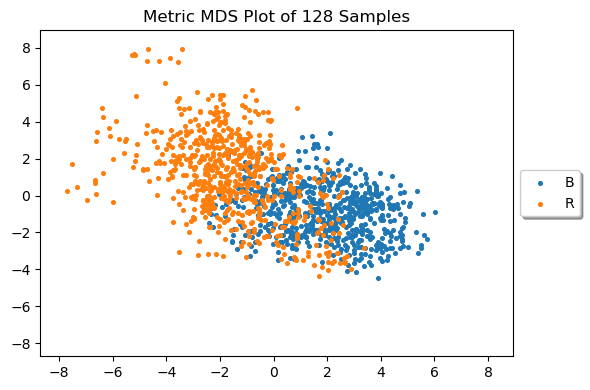

In [50]:
plt.figure(figsize=(6, 4))
# plt.subplot(1, 2, 1)
plt.title(f"Metric MDS Plot of {len(samples)} Samples")
x, y = mod_mds.T
plt.scatter(x[:len(mod_mds)//2], y[:len(mod_mds)//2], label="B", s=7)
plt.scatter(x[len(mod_mds)//2:], y[len(mod_mds)//2:], label="R", s=7)
plt.xlim((np.min(mod_mds) - 1, np.max(mod_mds) + 1))
plt.ylim((np.min(mod_mds) - 1, np.max(mod_mds) + 1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)

# plt.subplot(1, 2, 2)
# plt.title("MDS Stress Scree Plot")
# plt.plot(*mds_stress)
# plt.xlabel("Number of Components")
# plt.ylabel("1 - Cumulative Stress")
# plt.tight_layout()
# plt.savefig("mds_scree_plot.png")
plt.tight_layout()
plt.show()

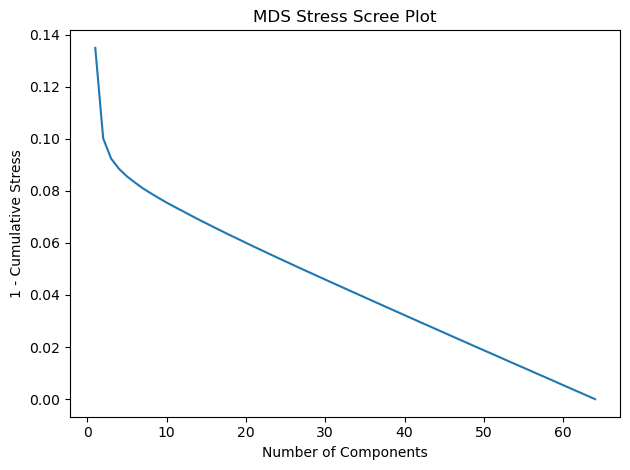

In [25]:
plt.title("MDS Stress Scree Plot")
plt.plot(*mds_stress)
plt.xlabel("Number of Components")
plt.ylabel("1 - Cumulative Stress")
plt.tight_layout()
plt.show()

## Clustering

In [26]:
encoded_subsamples.shape

(10, 10, 64)

In [27]:
flat_encoded_samples = encoded_subsamples.reshape((-1, encoded_subsamples.shape[-1]))

In [28]:
kmeans = KMeans(n_clusters=len(encoded_subsamples))
labels = kmeans.fit_predict(flat_encoded_samples)
labels

array([1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 8, 5,
       8, 2, 2, 8, 2, 8, 2, 2, 4, 4, 4, 4, 6, 4, 6, 4, 6, 4, 1, 9, 0, 0,
       0, 0, 0, 1, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 9, 9, 1, 1,
       1, 1, 0, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 9, 9, 9, 9, 2,
       9, 9, 8, 5, 5, 5, 5, 5, 5, 5, 8, 5], dtype=int32)

In [29]:
normalized_mutual_info_score(
    np.repeat(np.arange(len(encoded_subsamples)), encoded_subsamples.shape[1]),
    labels)

0.7699661232343326

### Agglomerative Clustering

In [30]:
model = AgglomerativeClustering(None, distance_threshold=0).fit(flat_encoded_samples)
# model = AgglomerativeClustering(len(encoded_subsamples)).fit(flat_encoded_samples)

In [31]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [32]:
model.labels_

array([56, 93, 89, 81, 60, 92, 95, 71, 69, 86, 99, 88, 55, 65, 90, 76, 50,
       75, 59, 49, 79, 72, 73, 85, 29, 97, 44, 51, 87, 27, 91, 45, 77, 74,
       96, 94, 42, 36, 61, 64, 43, 63, 98, 78, 58, 57, 54, 80, 35, 21, 46,
       47, 68, 82, 83, 24, 67, 84, 40, 62, 66, 28, 39, 52, 41, 37, 38, 18,
       30, 53, 33, 17, 26, 20, 70, 31, 22, 19, 10, 32, 15, 34, 25, 16, 48,
       12,  9, 23, 13,  7, 14,  8,  4, 11,  5,  6,  3,  1,  2,  0])

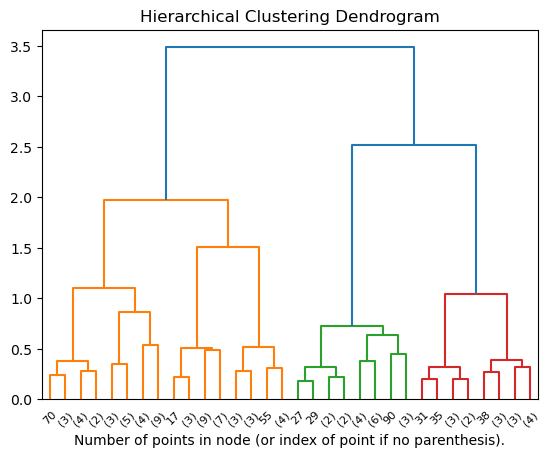

In [37]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()